In [1]:
"""LECTURA DE DATAFRAME ,FILTRADO DE COLUMNAS DE INTERES Y CREACION DE DUMMIES"""
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import numpy as np
import statsmodels.api as sm
from sklearn.decomposition import PCA


data = pd.read_csv('../desafio_ds/df_clean.csv')
cols = ['property_type', 'place_name',  'state_name' ,\
 'surface_total_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses',\
 'pileta|piscina', 'terraza|solarium', 'cochera|garage', 'patio|jardin', 'laundry|lavadero', \
 'parrilla|churrasquera|asadera', 'amenities']
df = data[cols]



In [2]:
"""REVISO SI LAS FEATURES TIENEN CORRELACION ALTA CON EL TARGET"""
def corr_filter(df,y= 'price_usd_per_m2', val=0.001):
    df_aux = pd.get_dummies(df, drop_first=True)
    x = df_aux.drop(y, axis = 1)
    lista = []
    for i in x.columns:
        corr = df_aux[[y,i]].corr()
        if corr.iloc[0][i] > abs(val):
            lista.append(i)
    return lista

lista = corr_filter(df,y= 'price_usd_per_m2', val=0.2)
print('FEATURES CON COFICIENTE DE CORRELACION > 0.2: {0}'.format(lista))
print('TOTAL DE FEATURES CORRELACION > 0.2: {0}'.format(len(lista)))

FEATURES CON COFICIENTE DE CORRELACION > 0.2: ['floor', 'property_type_apartment', 'place_name_Palermo', 'place_name_Puerto Madero', 'state_name_Capital Federal']
TOTAL DE FEATURES CORRELACION > 0.2: 5


In [3]:
def aplico_ridge(df,state_name):
    lista = []
    if type(state_name) == str:
        lista.append(state_name)
    else:
        lista = state_name
    lm_ridge = linear_model.RidgeCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                          0.05, 0.1,0.5,1,5,10,15], normalize=True, cv=5)
    df = df[df['state_name'].isin(lista)]
    df = pd.get_dummies(df, drop_first=True)
    X = df.drop('price_usd_per_m2',axis=1)
    y = df['price_usd_per_m2']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
    lm_ridge.fit(X_train, y_train)
    y_predicted = lm_ridge.predict(X_test)

    print("Best alpha using built-in RidgeCV: %f" % lm_ridge.alpha_)
    print("Best score using built-in RidgeCV: %f" %lm_ridge.score(X,y))
    coef = pd.Series(lm_ridge.coef_, index = X.columns)
    print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    train_score=lm_ridge.score(X_train,y_train)
    test_score=lm_ridge.score(X_test,y_test)
    coeff_used = np.sum(lm_ridge.coef_!=0)
    print("training score:", train_score)
    print("test score: ", test_score)
    print("number of features used: ", coeff_used)
    
    imp_coef = coef.sort_values(ascending=False).nlargest(30)
    plt.rcParams['figure.figsize'] = (15.0, 20.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Ridge Model")

In [4]:
"""TEST CON LASSO"""
def aplico_lasso(df,state_name):
    lista = []
    if type(state_name) == str:
        lista.append(state_name)
    else:
        lista = state_name       
    df = df[df['state_name'].isin(lista)]
    df = pd.get_dummies(df, drop_first=True)
    X = df.drop('price_usd_per_m2',axis=1)
    y = df['price_usd_per_m2']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
    reg = LassoCV(alphas=[0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                            0.05],\
                                            normalize=True, cv=5,max_iter=15000)
    reg.fit(X_train, y_train)
    print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
    print("Best score using built-in LassoCV: %f" %reg.score(X,y))
    coef = pd.Series(reg.coef_, index = X.columns)
    print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    train_score=reg.score(X_train,y_train)
    test_score=reg.score(X_test,y_test)
    coeff_used = np.sum(reg.coef_!=0)
    print("training score:", train_score) 
    print("test score: ", test_score)
    print("number of features used: ", coeff_used)
    imp_coef = coef.sort_values(ascending=False).nlargest(30)
    plt.rcParams['figure.figsize'] = (15.0, 20.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Lasso Model")


lasso BUENOS AIRES

Best alpha using built-in LassoCV: 0.005000
Best score using built-in LassoCV: 0.579488
Lasso picked 519 variables and eliminated the other 104 variables
training score: 0.5799156010176671
test score:  0.5781968176718075
number of features used:  519

lasso CAPITAL

Best alpha using built-in LassoCV: 0.050000
Best score using built-in LassoCV: 0.488061
Lasso picked 58 variables and eliminated the other 17 variables
training score: 0.4884956542584553
test score:  0.48674103467410057
number of features used:  58

lasso FULL

Best alpha using built-in LassoCV: 0.010000
Best score using built-in LassoCV: 0.580760
Lasso picked 543 variables and eliminated the other 307 variables
training score: 0.5814915062801449
test score:  0.5785059337235166
number of features used:  543


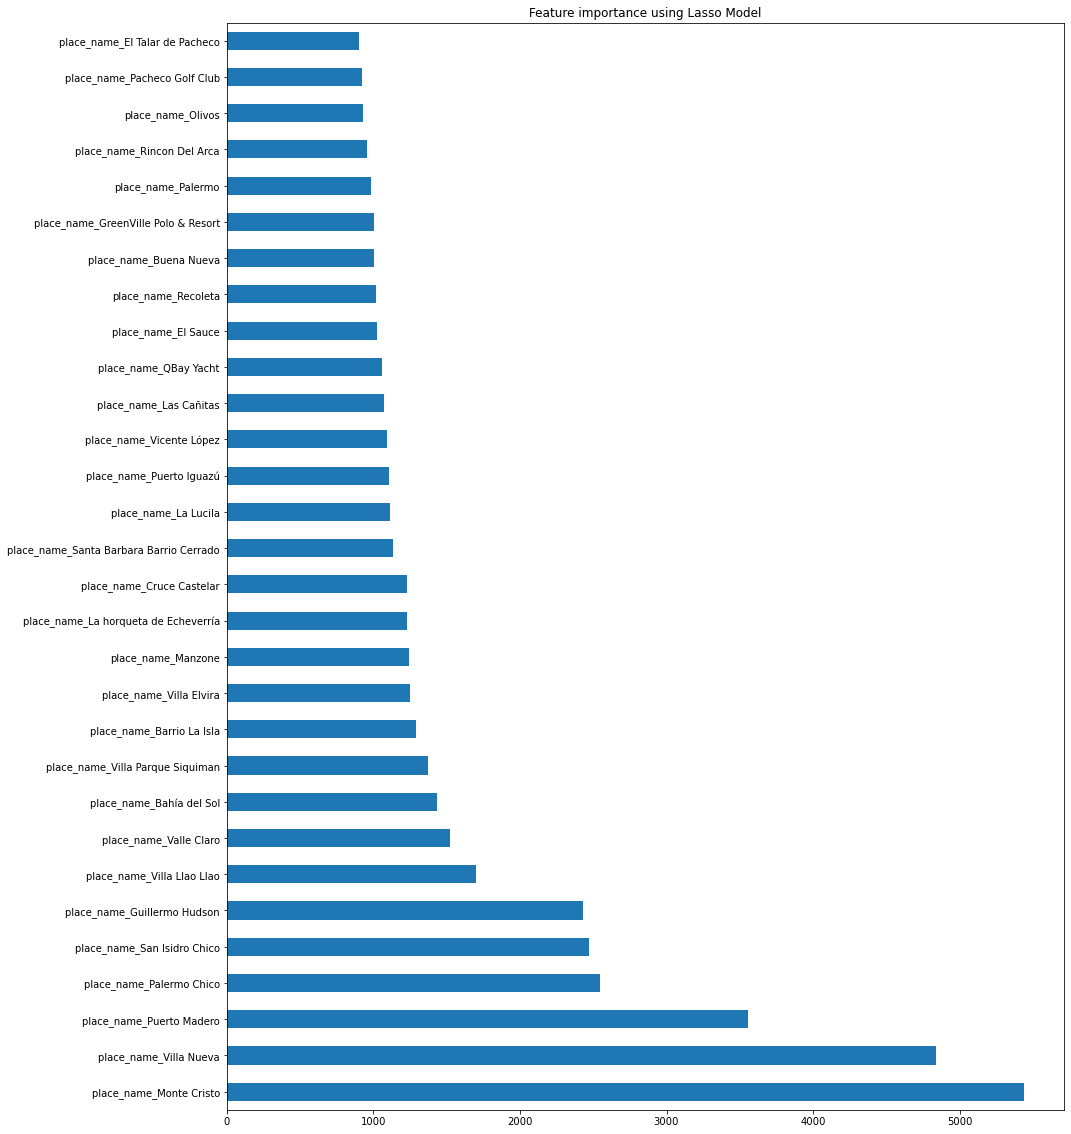

In [5]:
print("\nlasso BUENOS AIRES\n")
aplico_lasso(df,['Capital Federal','Buenos Aires Interior','Bs.As. G.B.A. Zona Sur','Buenos Aires Costa Atlántica','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Oeste'])
print("\nlasso CAPITAL\n")
aplico_lasso(df,'Capital Federal')
print("\nlasso FULL\n")
aplico_lasso(df,df["state_name"].to_list())

In [6]:
"""lasso BUENOS AIRES

Best alpha using built-in LassoCV: 0.005000
Best score using built-in LassoCV: 0.579488
Lasso picked 519 variables and eliminated the other 104 variables
training score: 0.5799156010176671
test score:  0.5781968176718074
number of features used:  519

lasso CAPITAL

Best alpha using built-in LassoCV: 0.050000
Best score using built-in LassoCV: 0.488061
Lasso picked 58 variables and eliminated the other 17 variables
training score: 0.4884956542584552
test score:  0.48674103467410057
number of features used:  58

lasso FULL

Best alpha using built-in LassoCV: 0.010000
Best score using built-in LassoCV: 0.580760
Lasso picked 543 variables and eliminated the other 307 variables
training score: 0.5814915062801449
test score:  0.5785059337235166
number of features used:  543

ridge BUENOS AIRES

Best alpha using built-in RidgeCV: 0.000010
Best score using built-in RidgeCV: 0.578991
Ridge picked 596 variables and eliminated the other 27 variables
training score: 0.5804484570938384
test score:  0.574596088622152
number of features used:  596

ridge CAPITAL

Best alpha using built-in RidgeCV: 1.000000
Best score using built-in RidgeCV: 0.399881
Ridge picked 74 variables and eliminated the other 1 variables
training score: 0.4016596420414748
test score:  0.3944841625562817
number of features used:  74

ridge FULL

Best alpha using built-in RidgeCV: 0.050000
Best score using built-in RidgeCV: 0.582042
Ridge picked 801 variables and eliminated the other 49 variables
training score: 0.5832675534155107
test score:  0.5782676502220105
number of features used:  801

"""

'lasso BUENOS AIRES\n\nBest alpha using built-in LassoCV: 0.005000\nBest score using built-in LassoCV: 0.579488\nLasso picked 519 variables and eliminated the other 104 variables\ntraining score: 0.5799156010176671\ntest score:  0.5781968176718074\nnumber of features used:  519\n\nlasso CAPITAL\n\nBest alpha using built-in LassoCV: 0.050000\nBest score using built-in LassoCV: 0.488061\nLasso picked 58 variables and eliminated the other 17 variables\ntraining score: 0.4884956542584552\ntest score:  0.48674103467410057\nnumber of features used:  58\n\nlasso FULL\n\nBest alpha using built-in LassoCV: 0.010000\nBest score using built-in LassoCV: 0.580760\nLasso picked 543 variables and eliminated the other 307 variables\ntraining score: 0.5814915062801449\ntest score:  0.5785059337235166\nnumber of features used:  543\n\nridge BUENOS AIRES\n\nBest alpha using built-in RidgeCV: 0.000010\nBest score using built-in RidgeCV: 0.578991\nRidge picked 596 variables and eliminated the other 27 vari


ridge BUENOS AIRES

Best alpha using built-in RidgeCV: 0.000010
Best score using built-in RidgeCV: 0.578991
Ridge picked 596 variables and eliminated the other 27 variables
training score: 0.5804484570938384
test score:  0.574596088622152
number of features used:  596

ridge CAPITAL

Best alpha using built-in RidgeCV: 1.000000
Best score using built-in RidgeCV: 0.399881
Ridge picked 74 variables and eliminated the other 1 variables
training score: 0.40165964204147475
test score:  0.3944841625562817
number of features used:  74

ridge FULL

Best alpha using built-in RidgeCV: 0.050000
Best score using built-in RidgeCV: 0.582042
Ridge picked 801 variables and eliminated the other 49 variables
training score: 0.5832675534155107
test score:  0.5782676502220105
number of features used:  801


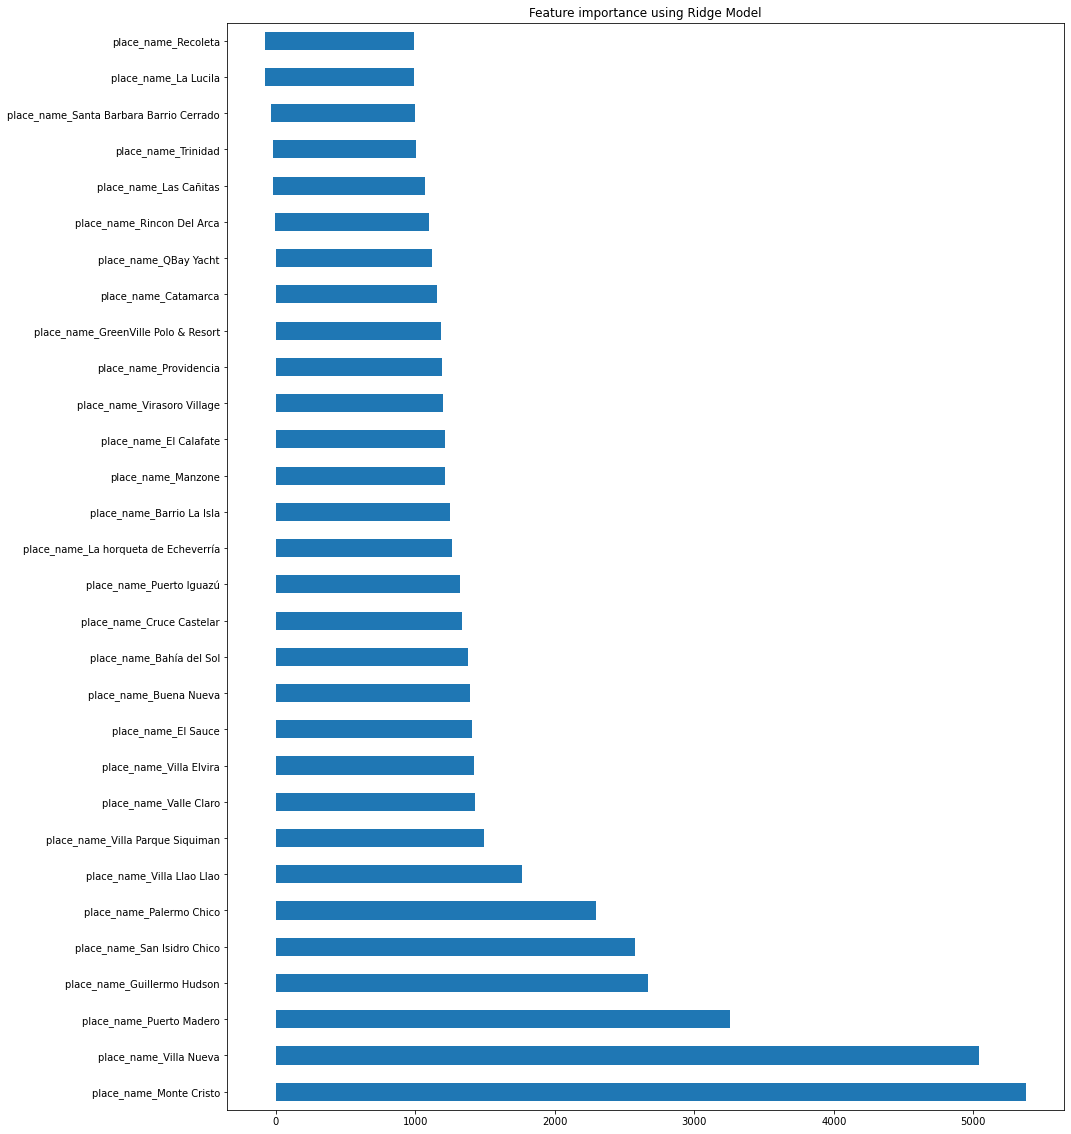

In [7]:
print("\nridge BUENOS AIRES\n")
aplico_ridge(df,['Capital Federal','Buenos Aires Interior','Bs.As. G.B.A. Zona Sur','Buenos Aires Costa Atlántica','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Oeste'])
print("\nridge CAPITAL\n")
aplico_ridge(df,'Capital Federal')
print("\nridge FULL\n")
aplico_ridge(df,df["state_name"].to_list())